# ***`Module 2 Homework`***
---

In this homework, we're going to combine data from various sources to process it in Pandas and generate additional fields.

If not stated otherwise, please use the Colab covered at the livestream to re-use the code snippets.

---
## ***`Initial Public Offering`***

- "IPO" in stock markets stands for Initial Public Offering. It refers to the process where a private company offers shares to the public for the first time. This move to go public is often undertaken by companies seeking to raise capital to expand, reduce debt, or for other financial reasons. After an IPO, the company's shares are listed on a stock exchange, where they can be bought and sold by investors.
#
- IPO filings are the formal documents that a company submits to securities regulators before it can proceed with an Initial Public Offering (IPO). These filings are essential because they provide detailed information about the company's business, financial status, and management.

In [1]:
# IMPORTS
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.express as px

import time
from datetime import date

import requests

# for graphs
import matplotlib.pyplot as plt
import seaborn as sns

## ***`Question 1: IPO Filings Web Scraping and Data Processing`***
---

What's the total sum ($m) of 2023 filings that happened on Fridays?

Re-use the [Code Snippet 1] example to get the data from web for this endpoint: https://stockanalysis.com/ipos/filings/ Convert the 'Filing Date' to datetime(), 'Shares Offered' to float64 (if '-' is encountered, populate with NaNs). Define a new field 'Avg_price' based on the "Price Range", which equals to NaN if no price is specified, to the price (if only one number is provided), or to the average of 2 prices (if a range is given). You may be inspired by the function extract_numbers() in [Code Snippet 4], or you can write your own function to "parse" a string. Define a column "Shares_offered_value", which equals to "Shares Offered" * "Avg_price" (when both columns are defined; otherwise, it's NaN)

Find the total sum in $m (millions of USD, closest INTEGER number) for all filings during 2023, which happened on Fridays (Date.dt.dayofweek()==4). You should see 32 records in total, 25 of it is not null.

(additional: you can read about S-1 IPO filing to understand the context: https://www.dfinsolutions.com/knowledge-hub/thought-leadership/knowledge-resources/what-s-1-ipo-filing)

- Read data:

In [17]:
import requests

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
}

url = "https://stockanalysis.com/ipos/filings/"
response = requests.get(url, headers=headers)

ipo_dfs = pd.read_html(response.text)
print(f"Type: {type(ipo_dfs)}; N elements: {len(ipo_dfs)}")
ipo_dfs

Type: <class 'list'>; N elements: 2


/var/folders/w6/jtmt_0cj77x4nfxlghckk_zc0000gn/T/ipykernel_4025/2618181750.py:10: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  ipo_dfs = pd.read_html(response.text)


[      Filing Date Symbol                           Company Name  \
 0     May 3, 2024    TBN         Tamboran Resources Corporation   
 1    Apr 29, 2024   HWEC                   HW Electro Co., Ltd.   
 2    Apr 29, 2024   DTSQ  DT Cloud Star Acquisition Corporation   
 3    Apr 26, 2024   EURK                Eureka Acquisition Corp   
 4    Apr 26, 2024    HDL    Super Hi International Holding Ltd.   
 ..            ...    ...                                    ...   
 320  Jan 21, 2020   GOXS                            Goxus, Inc.   
 321  Jan 21, 2020   UTXO                 UTXO Acquisition, Inc.   
 322   Dec 9, 2019   LOHA                           Loha Co. Ltd   
 323   Oct 4, 2019   ZGHB  China Eco-Materials Group Co. Limited   
 324  Dec 27, 2018   FBOX              Fit Boxx Holdings Limited   
 
         Price Range Shares Offered  
 0                 -              -  
 1             $3.00        3750000  
 2            $10.00        6000000  
 3            $10.00        50

- Inspect all tables:

In [18]:
ipo_dfs[0].head()

,Filing Date,Symbol,Company Name,Price Range,Shares Offered
0,"May 3, 2024",TBN,Tamboran Resources Corporation,-,-
1,"Apr 29, 2024",HWEC,"HW Electro Co., Ltd.",$3.00,3750000
2,"Apr 29, 2024",DTSQ,DT Cloud Star Acquisition Corporation,$10.00,6000000
3,"Apr 26, 2024",EURK,Eureka Acquisition Corp,$10.00,5000000
4,"Apr 26, 2024",HDL,Super Hi International Holding Ltd.,-,-


In [19]:
ipo_dfs[1].head()

,Date,Symbol,Name
0,May 8,NNE,Nano Nuclear Energy
1,May 9,SVCO,Silvaco Group
2,May 9,PAL,Proficient Auto Logistics
3,May 10,ZK,ZEEKR Intelligent Technology Holding
4,May 10,LRTX,Lirum Therapeutics


In [23]:
filings_df = ipo_dfs[0]
filings_df.dtypes.to_frame(name="Data Type")

,Data Type
Filing Date,object
Symbol,object
Company Name,object
Price Range,object
Shares Offered,object


- Data Cleaning & Feature Extraction:

In [33]:
# 0) extract data for year 2023
filings_23 = filings_df[filings_df['Filing Date'].str.contains('2023')].copy()

# 1) convert filing date to datetime
filings_23['Filing Date'] = pd.to_datetime(filings_23['Filing Date'])

# 2) 'Shares Offered' to float64 (if '-' is encountered, populate with NaNs)
filings_23['Shares Offered'] = filings_23['Shares Offered'].apply(lambda x: np.nan if x == '-' else float(x))

# 3) Define a new field 'Avg_price' based on the "Price Range", which equals to NaN if no price is specified, to the price (if only one number is provided), or to the average of 2 prices (if a range is given). You may be inspired by the function extract_numbers() in [Code Snippet 4], or you can write your own function to "parse" a string.
def extract_numbers(price_range:str) -> float:
    # Extracts numbers from the price range string and calculates the average price
    if pd.isna(price_range):
        return np.nan
    numbers = [float(x) for x in price_range.replace('$', '').split() if x.replace('.', '', 1).isdigit()]
    if len(numbers) == 1:
        return numbers[0]
    elif len(numbers) == 2:
        return sum(numbers) / 2
    return np.nan

filings_23['Avg_price'] = filings_23['Price Range'].apply(extract_numbers)


# Define a column "Shares_offered_value", which equals to "Shares Offered" * "Avg_price" (when both columns are defined; otherwise, it's NaN)
filings_23['Shares_offered_value'] = filings_23['Shares Offered'] * filings_23['Avg_price']

# Filter for filings that happened on Fridays in 2023
mask = (filings_23['Filing Date'].dt.year == 2023) & (filings_23['Filing Date'].dt.dayofweek == 4) # You should see 32 records in total, 25 of it is not null.
friday_filings = filings_23[ mask ].copy()


print(friday_filings.shape)
friday_filings.head(9)

(32, 7)


,Filing Date,Symbol,Company Name,Price Range,Shares Offered,Avg_price,Shares_offered_value
50,2023-12-29,LEC,Lafayette Energy Corp,$3.50 - $4.50,1200000.0,4.0,4800000.0
51,2023-12-29,EPSM,Epsium Enterprise Limited,-,NaN,NaN,NaN
54,2023-12-22,CHLW,Chun Hui Le Wan International Holding Group Ltd,-,NaN,NaN,NaN
55,2023-12-22,LZMH,LZ Technology Holdings Limited,-,NaN,NaN,NaN
60,2023-12-15,GIT,Going International Holding Company Limited,-,NaN,NaN,NaN
62,2023-12-08,ENGS,Energys Group Limited,$4.00 - $6.00,2000000.0,5.0,10000000.0
63,2023-12-08,LNKS,Linkers Industries Limited,$4.00 - $6.00,2200000.0,5.0,11000000.0
82,2023-10-27,RAY,Raytech Holding Limited,$4.00 - $5.00,1500000.0,4.5,6750000.0
89,2023-10-13,ORIS,Oriental Rise Holdings Limited,$4.00,2000000.0,4.0,8000000.0


In [36]:
mask = (filings_23['Filing Date'].dt.year == 2023) & (filings_23['Filing Date'].dt.dayofweek == 3) # You should see 32 records in total, 25 of it is not null.
thursday_filings = filings_23[ mask ].copy()

- Result:

In [37]:
# Calculate the total sum in millions of USD
total_sum_friday   = friday_filings['Shares_offered_value'].sum() / 1e6
total_sum_thursday = thursday_filings['Shares_offered_value'].sum() / 1e6

# Print the result
print(f"Total sum of 2023 filings on Fridays: ${total_sum_friday:.0f} million")
print(f"Total records: {len(friday_filings)}, Non-null values: {friday_filings['Shares_offered_value'].notna().sum()}")
print()
print(f"Total sum of 2023 filings on Thursdays: ${total_sum_thursday:.0f} million")
print(f"Total records: {len(thursday_filings)}, Non-null values: {thursday_filings['Shares_offered_value'].notna().sum()}")

Total sum of 2023 filings on Fridays: $286 million
Total records: 32, Non-null values: 25

Total sum of 2023 filings on Thursdays: $414 million
Total records: 23, Non-null values: 17


### ***Context:***
---
#### ***1. Understanding IPO Dynamics***
- Initial Public Offerings (IPOs) are significant events in the stock market as they represent a company's transition from private to public. Analyzing IPOs helps understand market trends, investor appetite, and how different factors affect the initial market reception of new public companies.
#
- By analyzing IPO filings, you get insights into the sectors attracting investment, the size of companies going public, and other market dynamics.

#### ***2. Temporal Analysis (Focus on Fridays)***
- Analyzing IPOs based on the day of the week they are filed provides insights into strategic decisions made by companies and underwriters. There is a belief in financial circles that the timing of an IPO can affect its initial performance and subsequent investor interest.
#
- Fridays are particularly interesting because they are at the end of the trading week, which might influence how much attention the IPO gets. Market participants might react differently to IPOs based on their timing, with some days believed to be more favorable for announcements and listings due to psychological and behavioral factors of investors.

#### ***4. Quantitative Analysis***
- Calculating the total monetary value of IPOs on specific days can help quantify the economic significance of these filings. This can lead to more detailed analysis, like comparing different days or looking for trends over time.

#### ***5. Thursday vs. Friday Comparison***
The analysis of IPO filings on Thursdays and Fridays in 2023 reveals some notable trends and differences:

- **Higher Capital on Thursdays:** Despite fewer IPOs (23 on Thursday vs. 32 on Friday), Thursdays saw more capital raised, totaling $414 million, compared to $286 million on Fridays. This suggests that the average IPO size on Thursdays is larger than on Fridays.
#
- **Implications for Strategic Timing:** The difference in capital raised may indicate that companies opting for Thursday IPOs are either larger or issue shares at higher prices, possibly to capture a more engaged investor audience ahead of the weekend.
#
- **Potential Market Preferences:** The preference for Thursday could reflect investor behaviors or market sentiments that favor absorbing and acting on new financial events earlier in the week, avoiding the weekend slowdown.
#
- **Further Analysis Opportunities:** These findings open the door to deeper analyses, such as comparing these days with other weekdays, exploring sector-specific trends, and assessing post-IPO performance metrics to understand broader market implications and investor responses.

---

- Pattern Analysis for all days:

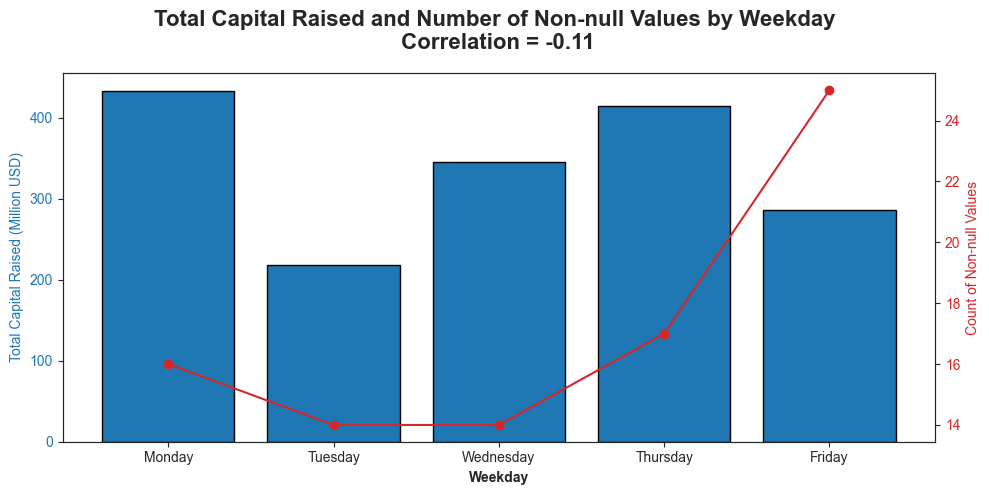

In [55]:
import pandas as pd
import seaborn as sns
sns.set_style("ticks")

# Assuming filings_23 is already loaded and 'Filing Date' is converted to datetime
# Filter for year 2023 and add weekday names
filings_23['weekday'] = filings_23['Filing Date'].dt.weekday
filings_23 = filings_23[filings_23['Filing Date'].dt.year == 2023]

# Group by weekday to calculate sums and counts
summary = filings_23.groupby(filings_23['Filing Date'].dt.day_name())['Shares_offered_value'].agg(['sum', 'count'])
summary['sum'] /= 1e6  # Convert to millions of USD

# Sorting index by day of the week to ensure correct order (Monday to Friday)
summary = summary.reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"])

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 5))
corr = summary['sum'].corr(summary['count'])
fig.suptitle(f'Total Capital Raised and Number of Non-null Values by Weekday\n Correlation = {corr:.2f}', fontsize=16, weight='bold')

# Bar plot for total sum of shares offered in millions of USD
color = 'tab:blue'
ax1.set_xlabel('Weekday', weight='bold')
ax1.set_ylabel('Total Capital Raised (Million USD)', color=color)
ax1.bar(summary.index, summary['sum'], color=color, edgecolor='black')
ax1.tick_params(axis='y', labelcolor=color)

# Create a twin axis for the count of non-null values
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Count of Non-null Values', color=color)
ax2.plot(summary.index, summary['count'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # To ensure there's no layout overlap
plt.show()


In [173]:
summary.head()

,sum,count
Filing Date,,
Monday,433.037500,16
Tuesday,218.335438,14
Wednesday,344.800004,14
Thursday,414.247503,17
Friday,285.700000,25


<Axes: xlabel='sum', ylabel='count'>

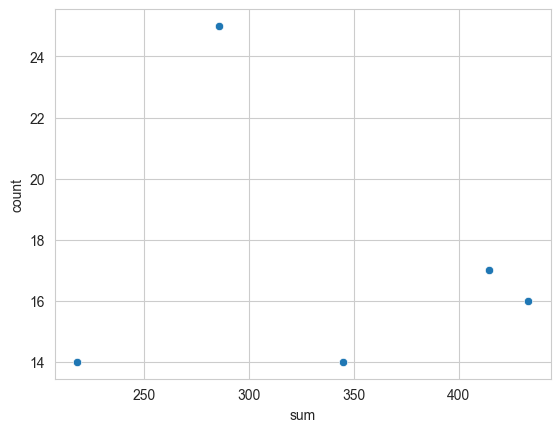

In [174]:
sns.scatterplot(data =summary, x='sum', y='count')

## ***`Question 2: IPOs "Fixed days hold" strategy`***
---

Find the optimal number of days X (between 1 and 30), where 75% quantile growth is the highest?

Reuse [Code Snippet 1] to retrieve the list of IPOs from 2023 and 2024 (from URLs: https://stockanalysis.com/ipos/2023/ and https://stockanalysis.com/ipos/2024/). Get all OHLCV daily prices for all stocks with an "IPO date" before March 1, 2024 ("< 2024-03-01") - 184 tickers (without 'RYZB'). Please remove 'RYZB', as it is no longer available on Yahoo Finance.

Sometimes you may need to adjust the symbol name (e.g., 'IBAC' on stockanalysis.com -> 'IBACU' on Yahoo Finance) to locate OHLCV prices for all stocks. Also, you can see the ticker changes using this link:https://stockanalysis.com/actions/changes/. Some of the tickers (like 'DYCQ' and 'LEGT') were on the market less than 30 days (11 and 21 days, respectively). Let's leave them in the dataset; it just means that you couldn't hold them for more days than they were listed.

Let's assume you managed to buy a new stock (listed on IPO) on the first day at the [Adj Close] price]. Your strategy is to hold for exactly X full days (where X is between 1 and 30) and sell at the "Adj. Close" price in X days (e.g., if X=1, you sell on the next day). Find X, when the 75% quantile growth (among 185 investments) is the highest.

HINTs:

- You can generate 30 additional columns: growth_future_1d ... growth_future_30d, join that with the table of min_dates (first day when each stock has data on Yahoo Finance), and perform vector operations on the resulting dataset.
#
- You can use the DataFrame.describe() function to get mean, min, max, 25-50-75% quantiles.

Additional:

- You can also ensure that the mean and 50th percentile (median) investment returns are negative for most X values, implying a wager for a "lucky" investor who might be in the top 25%.
#
- What's your recommendation: Do you suggest pursuing this strategy for an optimal X?
---

### ***Attempt #2***

- Rettrieve all ipo symbols and dates:

In [2]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
}

url_23, url_24 = "https://stockanalysis.com/ipos/2023/", "https://stockanalysis.com/ipos/2024/"

response_23, response_24 = requests.get(url_23, headers=headers), requests.get(url_24, headers=headers)

ipos_23, ipos_24 = pd.read_html(response_23.text)[0], pd.read_html(response_24.text)[0]

ipos_df = pd.concat([ipos_23, ipos_24]).reset_index(drop=True)

# select only neccessary columns
ipos_df = ipos_df[['IPO Date', 'Symbol']]

# datetime casting
ipos_df['IPO Date'] = pd.to_datetime(ipos_df['IPO Date'], format='%b %d, %Y', errors='coerce')

# filter
ipos_df = ipos_df[ipos_df['IPO Date'] < '2024-03-01']
# Remove the ticker that is not available
ipos_df = ipos_df[ipos_df['Symbol'] != 'RYZB']
# Check how many NaT values were generated
print(ipos_df['IPO Date'].isna().sum()) # great!!!

print(ipos_df.shape)
ipos_df.head()

0
(184, 2)


/var/folders/w6/jtmt_0cj77x4nfxlghckk_zc0000gn/T/ipykernel_9390/2875163406.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  ipos_23, ipos_24 = pd.read_html(response_23.text)[0], pd.read_html(response_24.text)[0]
/var/folders/w6/jtmt_0cj77x4nfxlghckk_zc0000gn/T/ipykernel_9390/2875163406.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  ipos_23, ipos_24 = pd.read_html(response_23.text)[0], pd.read_html(response_24.text)[0]


,IPO Date,Symbol
0,2023-12-27,IROH
1,2023-12-19,LGCB
2,2023-12-15,ZKH
3,2023-12-15,BAYA
4,2023-12-14,INHD


- map ipo names from first data source to the actual names from yahoo:

In [3]:
# firstly get actual symbol names for yahoo and map them
import requests
from bs4 import BeautifulSoup

url = "https://stockanalysis.com/actions/changes/"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
# Find the table, you might need to adjust this if there are multiple tables or identifiers
table = soup.find('table')  # Adjust with `id` or `class_` if necessary
rows = table.find_all('tr')

# Dictionary to hold the ticker changes
ticker_changes = {}

# Loop through rows and skip the header
for row in rows[1:]:  # assuming the first row is the header
    cols = row.find_all('td')
    if len(cols) >= 3:  # Make sure there are enough columns
        old_symbol = cols[1].text.strip()
        new_symbol = cols[2].text.strip()
        ticker_changes[old_symbol] = new_symbol

ticker_changes

{'CONX': 'CNXX',
 'FUV': 'FUVV',
 'XLYO': 'XYLO',
 'DCFCW': 'DCFWQ',
 'MDGS': 'XYLO',
 'GGE': 'GGEI',
 'CBD': 'CBDBY',
 'OSA': 'OSAP',
 'ARRW': 'AILE',
 'CNXA': 'YYAI',
 'STRC': 'PDYN',
 'KYCH': 'ZOOZ',
 'VIEWW': 'VIWWQ',
 'ASCA': 'NIVF',
 'CASA': 'CASSQ',
 'ONTX': 'TRAW',
 'APAC': 'FAAS',
 'WETG': 'NXTT',
 'GEV.W': 'GEV',
 'WNNR': 'ZPTA',
 'CVCY': 'CWBC',
 'TWOA': 'LPA',
 'AGE': 'SER',
 'CNDB': 'GCTS',
 'FIXX': 'QTTB',
 'DWAC': 'DJT',
 'FSR': 'FSRN',
 'FLT': 'CPAY',
 'VJET': 'VJTTY',
 'GRPH': 'LENZ',
 'ADOC': 'COOT',
 'HCMA': 'MRNO',
 'SVFD': 'NITO',
 'PUYI': 'HPH',
 'ENCP': 'GTI',
 'CYT': 'CYTT',
 'DHCA': 'BNAI',
 'XPDB': 'AIRJ',
 'ESAC': 'ZEO',
 'INPX': 'XTIA',
 'SASI': 'NTRP',
 'LBBB': 'NMHI',
 'GIA': 'QTI',
 'CPSI': 'TBRG',
 'PEAK': 'DOC',
 'BODY': 'BODI',
 'BFX': 'BFXXQ',
 'ARIZ': 'FUFU',
 'POL': 'POLCQ',
 'SZZL': 'CRML',
 'ROI': 'ROII',
 'TMST': 'MTUS',
 'AMEH': 'ASTH',
 'LCAA': 'LOT',
 'JT': 'JTCHY',
 'CHEA': 'SELX',
 'LGST': 'TVGN',
 'FLME': 'SOC',
 'PBAX': 'CERO',
 'SEAS': 'P

In [4]:
ipos_df['Symbol'] = ipos_df['Symbol'].map(ticker_changes).fillna(ipos_df['Symbol']) # fillna is used to keep the original symbol if no change is found
ipos_df.isnull().sum()

IPO Date    0
Symbol      0
dtype: int64

- Identify first available trading day and fetch data from yahoo finance:

In [6]:
from tqdm import tqdm

In [8]:
import yfinance as yf
import pandas as pd
from pandas.tseries.offsets import BDay  # Business days
import logging

logging.basicConfig(level=logging.WARNING)

def find_first_trading_day(ticker, ipo_date):
    ipo_date = pd.Timestamp(ipo_date, tz='UTC')
    # Set a preliminary period to look for the first trading day
    start_date = ipo_date - pd.Timedelta(days=5)
    end_date = ipo_date + pd.Timedelta(days=99)  # >>>>> 99 days ways was critical to find the first trading day for some tickers <<<<<<<

    # Fetch data over this range
    data = yf.download(ticker, start=start_date, end=end_date, timeout=30)

    # Find the first valid index (date with data)
    first_valid_date = data['Adj Close'].first_valid_index()
    return first_valid_date

def fetch_data_from_first_trading_day(ticker, first_trading_day):
    """Note that it accounts for businessdays.
    """
    if first_trading_day is not None:
        # Use business day offset to ensure 30 trading days
        end_date = first_trading_day + BDay(31)  # This ensures 30 business days ahead //// maybe try 31?

        # Fetch data between the first trading day and the calculated end date
        data = yf.download(ticker, start=first_trading_day, end=end_date, timeout=30)
        return data
    else:
        print(f"No trading data available for {ticker}")
        return None
    
    

# Dictionary to store data
ipo_data = {}
no_ipo_data = []

ipos = ipos_df.set_index('Symbol')['IPO Date'].to_dict()

for ticker, ipo_date in tqdm(ipos.items()):
    first_trading_day = find_first_trading_day(ticker, ipo_date)
    data = fetch_data_from_first_trading_day(ticker, first_trading_day)
    if data is not None and not data.empty:
        ipo_data[ticker] = data
    else:
        print(f"Data collection failed for {ticker}")
        no_ipo_data.append(ticker)

if len(no_ipo_data) == 0:
    print("Successfully retrieved the data for all tickers!")
else:
    print(f"Data missing for: {no_ipo_data}")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Successfully retrieved the data for all tickers!


In [9]:
# Example of checking for empty data
symbol_count = 0
for symbol, df in ipo_data.items():
    if df.empty:
        print(f"Data for {symbol} is empty!")
    symbol_count += 1
symbol_count

184

In [47]:
# check for missing values
#for symbol, df in ipo_data.items():
#    print(f"Missing values for {symbol}: {df.isnull().sum()}")

In [10]:
# - Investigate data fetching tool by checking how many days of data each trade:
# for each stock check ow many obersvations there are (days of data):
for symbol, df in ipo_data.items():
    print(f"{symbol}: {len(df)} observations")

IROH: 29 observations
LGCB: 29 observations
ZKH: 28 observations
BAYA: 29 observations
INHD: 28 observations
AFJK: 30 observations
GSIW: 29 observations
FEBO: 29 observations
PSQH: 29 observations
ELAB: 28 observations
RR: 29 observations
DDC: 28 observations
SHIM: 29 observations
GLAC: 28 observations
SGN: 29 observations
HG: 29 observations
CRGX: 29 observations
ANSC: 30 observations
AITR: 30 observations
GVH: 30 observations
LXEO: 30 observations
PAPL: 30 observations
ATGL: 30 observations
MNR: 30 observations
WBUY: 30 observations
NCL: 30 observations
BIRK: 31 observations
GMM: 31 observations
PMEC: 31 observations
LRHC: 31 observations
GPAK: 31 observations
SPKL: 29 observations
QETA: 29 observations
MSS: 31 observations
ANL: 31 observations
SYRA: 31 observations
VSME: 31 observations
LRE: 31 observations
TURB: 31 observations
MDBH: 31 observations
KVYO: 31 observations
CART: 31 observations
DTCK: 31 observations
NMRA: 31 observations
ARM: 31 observations
SPPL: 31 observations
NWG

In [11]:
# Example to print the first DataFrame's columns to verify structure
sample_symbol = next(iter(ipo_data))
print(ipo_data[sample_symbol].columns)
print(ipo_data[sample_symbol].head())

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
             Open   High     Low   Close  Adj Close  Volume
Date                                                       
2024-02-16  10.05  10.05  10.010  10.010     10.010   16700
2024-02-20  10.02  10.02  10.020  10.020     10.020    5200
2024-02-21  10.02  10.02  10.015  10.015     10.015   98600
2024-02-22  10.02  10.02  10.020  10.020     10.020    5600
2024-02-23  10.02  10.02  10.010  10.010     10.010   14800


- `See trend for all tickers:`

In [86]:
sns.set_style("whitegrid")

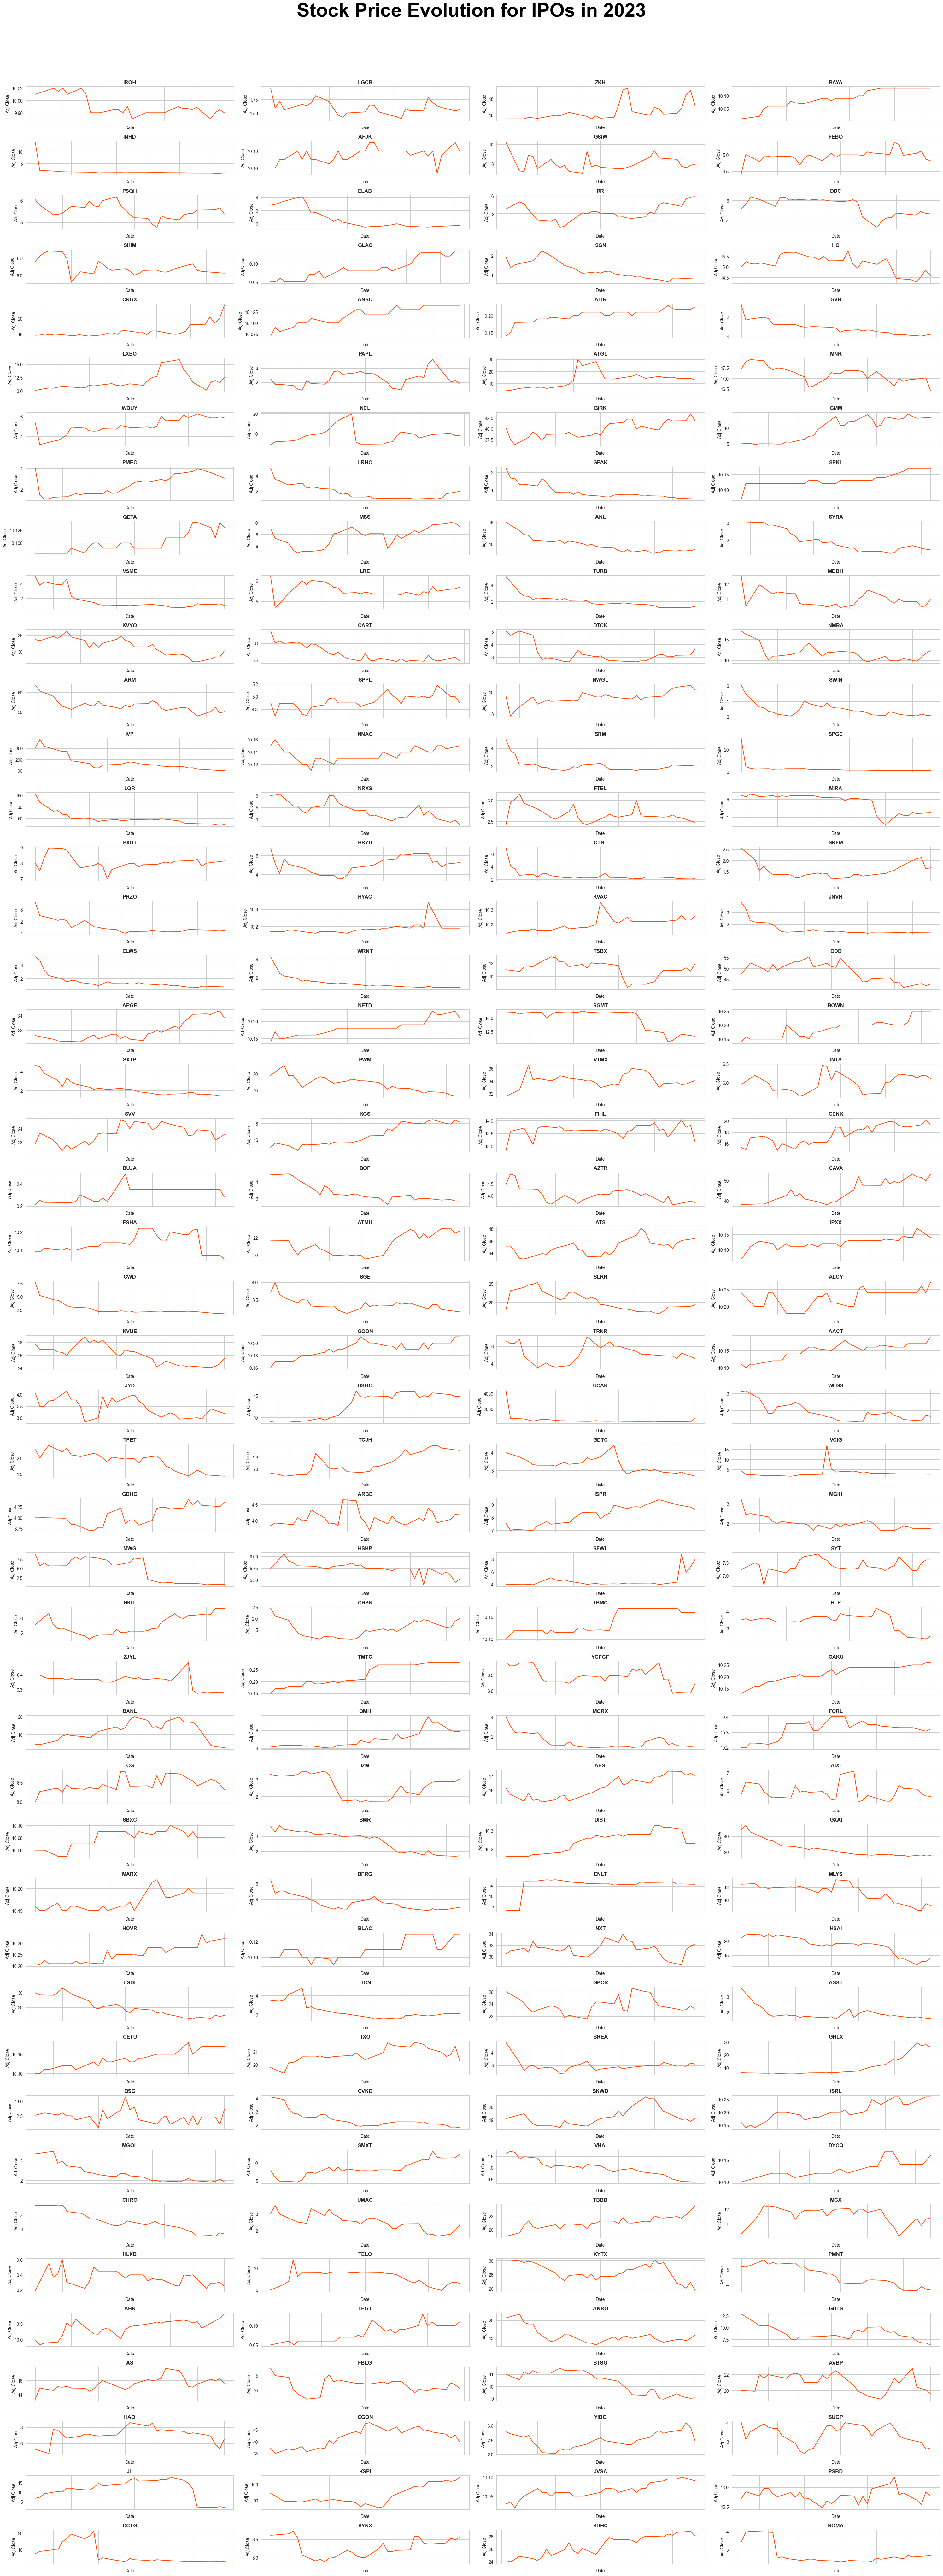

In [87]:
# Assuming `data_frames` is a dictionary containing data for each ticker
tickers   = list(ipo_data.keys())
n_tickers = len(tickers)

# Calculate the number of rows and columns needed
n_cols = 4
n_rows = (n_tickers + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(30, 80))
fig.suptitle('Stock Price Evolution for IPOs in 2023', weight='bold', size=44, y=1.02, x=0.5, color='black')
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot each ticker in its own subplot
for i, ticker in enumerate(tickers):

    sns.lineplot(data=ipo_data[ticker], x=ipo_data[ticker].index, y='Adj Close', ax=axes[i], color='orangered')
    axes[i].set_title(f'{ticker}', weight='bold')
    # get rid of x tick labels
    axes[i].set_xticklabels([])


plt.tight_layout();

- Calculate growth rates from first trading date `+30 or 31 days`:

In [14]:
def calculate_growth_rates(df, max_days=31):
    """Calculate growth rates from first day until every day up until the 30th day."""
    if df.empty or len(df['Adj Close']) < 2:
        return pd.Series()  # Return an empty series if there's not enough data

    # Assume 'Adj Close' is the column for adjusted closing prices
    initial_price = df['Adj Close'].iloc[0]
    days_data_available = min(len(df['Adj Close']), max_days)  # actual data length might be less than 31
    growth_rates = (df['Adj Close'].iloc[1:days_data_available] / initial_price - 1) * 100
    growth_rates.index = range(1, len(growth_rates) + 1)  # Adjust index to match day count

    return growth_rates

In [15]:
#def calculate_growth_rates(df, max_days=30):
#    """ Calculate growth rates from first day until every day up until the 30th day.
#    Args:
#        df (pd.DataFrame): DataFrame containing stock price data.
#        max_days (int): Maximum number of days to calculate growth rates for.
#    Returns:
#        pd.Series: Growth rates from day 0 to each day up to available days.
#    """
#    if df.empty or len(df) < 2:
#        return pd.Series()  # Return an empty series if there's not enough data#
#
    # Assume 'Adj Close' is the column for adjusted closing prices
#    initial_price = df['Adj Close'].iloc[0]
#    available_days = min(len(df['Adj Close']), max_days)  # Use the smaller of max_days or available data length
#    growth_rates = (df['Adj Close'].iloc[1:available_days] / initial_price - 1) * 100
#    growth_rates.index = range(1, len(growth_rates) + 1)  # Adjust index to match day count

#    return growth_rates


        
        
# Apply the function to each DataFrame in your dictionary
ticker_growth_rates = {}
for symbol, df in ipo_data.items():
    growth_rates = calculate_growth_rates(df)
    ticker_growth_rates[symbol] = growth_rates

ticker_growth_rates

{'IROH': 1     0.099902
 2     0.049951
 3     0.099902
 4     0.000000
 5     0.099902
 6     0.000000
 7    -0.299707
 8    -0.299707
 9    -0.299707
 10   -0.249756
 11   -0.249756
 12   -0.299707
 13   -0.199805
 14   -0.399600
 15   -0.299707
 16   -0.299707
 17   -0.299707
 18   -0.299707
 19   -0.299707
 20   -0.199805
 21   -0.229768
 22   -0.229768
 23   -0.249756
 24   -0.209789
 25   -0.399600
 26   -0.299707
 27   -0.249756
 28   -0.299707
 Name: Adj Close, dtype: float64,
 'LGCB': 1    -18.877551
 2    -12.244898
 3    -20.408168
 4    -15.510205
 5    -16.632658
 6    -14.081634
 7     -7.142856
 8    -12.755102
 9    -19.387754
 10   -25.510204
 11   -27.551024
 12   -23.469389
 13   -22.448982
 14   -15.969392
 15   -16.326533
 16   -22.448982
 17   -26.020407
 18   -27.040820
 19   -29.081635
 20   -19.387754
 21   -21.428575
 22   -20.969388
 23    -8.979592
 24   -13.775509
 25   -16.836737
 26   -18.367347
 27   -21.428575
 28   -20.408168
 Name: Adj Close, dtype: f

- Aggregate growth rates and analyze quantiles:

In [16]:
# Convert the dictionary of growth rates to a DataFrame
growth_df = pd.DataFrame.from_dict(ticker_growth_rates, orient='index')

# Calculate quantiles for each day
quantiles = growth_df.quantile(0.75)  # 75% quantile for each column
growth_df.head(9)

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
IROH,0.099902,0.049951,0.099902,0.000000,0.099902,0.000000,-0.299707,-0.299707,-0.299707,-0.249756,...,-0.229768,-0.229768,-0.249756,-0.209789,-0.399600,-0.299707,-0.249756,-0.299707,NaN,NaN
LGCB,-18.877551,-12.244898,-20.408168,-15.510205,-16.632658,-14.081634,-7.142856,-12.755102,-19.387754,-25.510204,...,-21.428575,-20.969388,-8.979592,-13.775509,-16.836737,-18.367347,-21.428575,-20.408168,NaN,NaN
ZKH,0.000000,0.000000,1.161292,0.838710,0.387099,2.903225,2.580643,4.000005,5.225803,1.935485,...,7.935481,3.870970,4.516134,8.451609,19.483874,22.838716,10.645159,NaN,NaN,NaN
BAYA,0.099902,0.399600,0.499502,0.499502,0.499502,0.689313,0.619374,0.599395,0.599395,0.799200,...,1.198800,1.198800,1.198800,1.198800,1.198800,1.198800,1.198800,1.198800,NaN,NaN
INHD,-84.643114,-86.661860,-87.779379,-88.680605,-89.185292,-89.257390,-90.050469,-90.987743,-89.149243,-89.617880,...,-92.213410,-92.285508,-92.357607,-92.357607,-93.056957,-93.006489,-91.881759,NaN,NaN,NaN
AFJK,0.000000,0.098427,0.098427,0.196855,0.098427,0.196855,0.098427,0.098427,0.049214,0.098427,...,0.196855,0.147641,0.196855,0.137795,0.196855,-0.059051,0.147641,0.295273,0.196855,NaN
GSIW,-28.627448,-29.215687,-12.647059,-14.215685,-26.176467,-17.058822,-22.549017,-24.999998,-23.039215,-29.117646,...,-8.235296,-15.686269,-15.980394,-16.960780,-23.823528,-25.499999,-22.941174,-21.862746,NaN,NaN
FEBO,12.837842,8.108111,11.261261,11.486481,11.261261,11.486481,11.486481,10.135131,5.630631,10.360361,...,12.837842,21.171172,19.819822,12.274776,13.738742,15.315311,9.684681,8.558561,NaN,NaN
PSQH,-4.139073,-11.423842,-11.258275,-10.264899,-5.132449,-5.960267,-0.993377,-4.635757,-5.463575,-0.662251,...,-15.397348,-11.589401,-10.596024,-10.430466,-7.781454,-7.450328,-6.125826,-10.927150,NaN,NaN


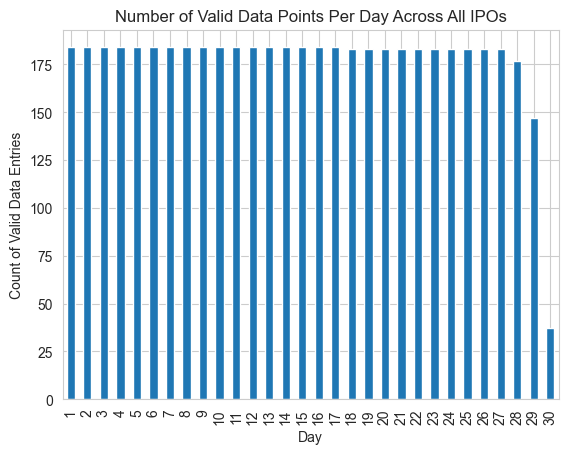

In [17]:
# Visualizing the number of valid entries per day
valid_data_counts = growth_df.count()
valid_data_counts.plot(kind='bar')
plt.title('Number of Valid Data Points Per Day Across All IPOs')
plt.xlabel('Day')
plt.ylabel('Count of Valid Data Entries')
plt.show()

In [18]:
quantiles

1     1.235190
2     1.840916
3     0.876190
4     0.892379
5     0.829491
6     0.689994
7     0.676009
8     0.694119
9     1.154540
10    1.220780
11    1.551593
12    1.601570
13    1.940195
14    1.970587
15    1.628372
16    1.419030
17    1.084282
18    1.416714
19    1.816311
20    1.514520
21    1.420901
22    2.821361
23    2.642805
24    2.888914
25    2.697230
26    2.825569
27    3.907142
28    3.859061
29    3.505892
30    0.695141
Name: 0.75, dtype: float64

- `Visualize distributions of quantiles for each growth rate:`

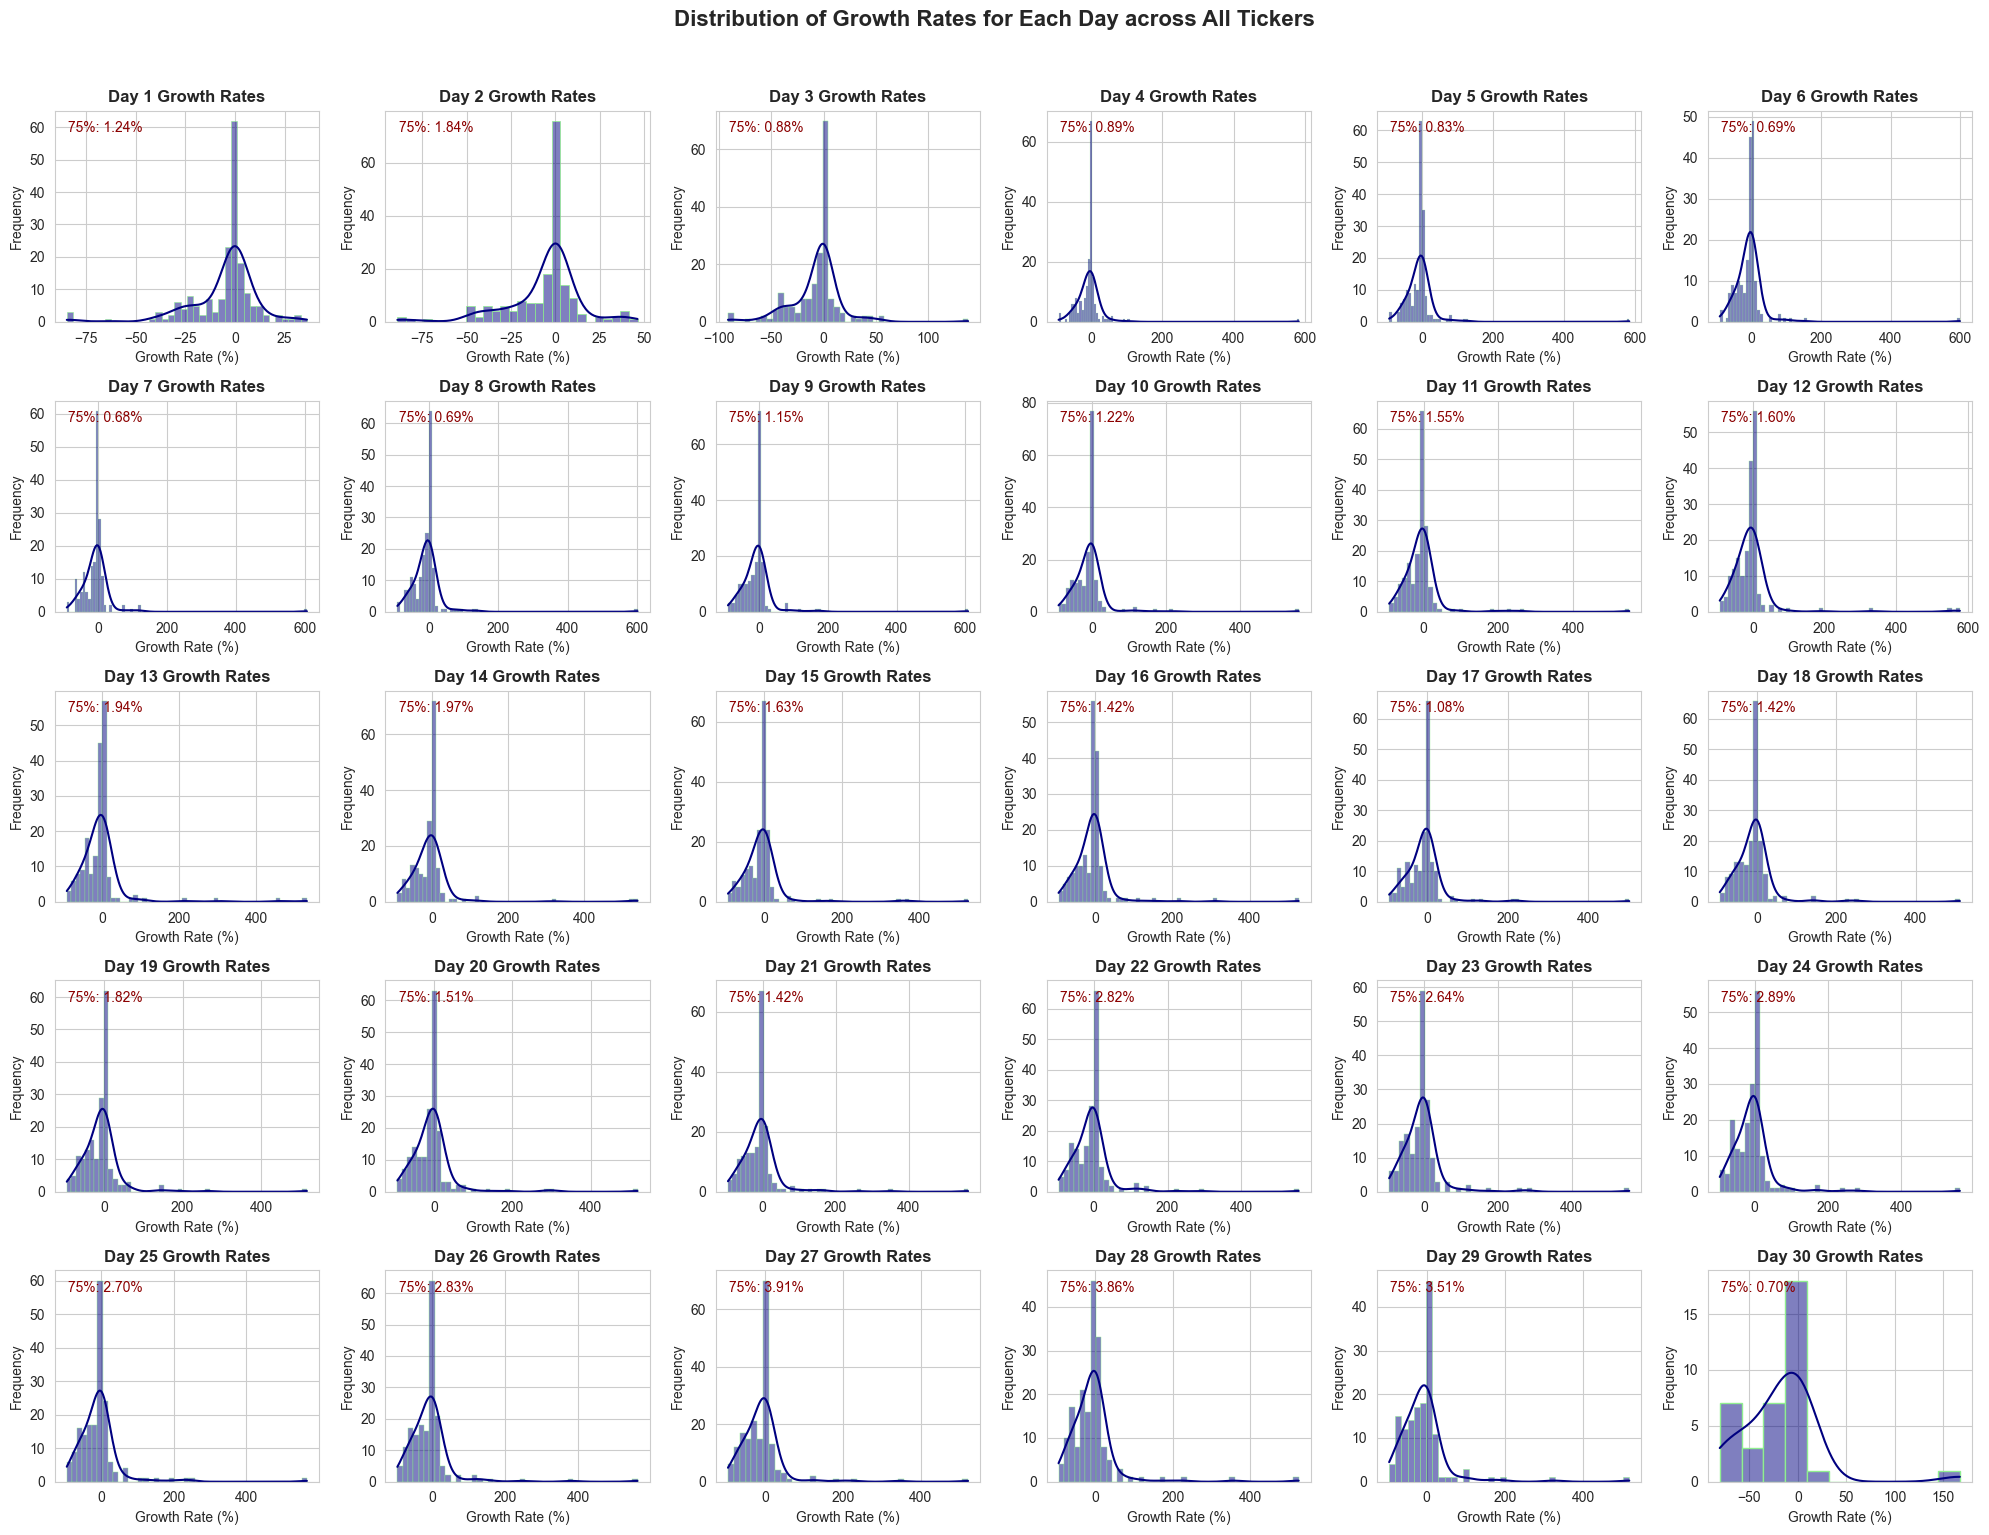

In [38]:
sns.set_style('whitegrid')
# Assume `growth_df` is already defined and contains growth data as described
days = growth_df.columns  # This gets all the column labels which are the days

# Plotting histograms for each day
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(20, 15))
fig.suptitle("Distribution of Growth Rates for Each Day across All Tickers", weight='bold', size=16, y=1.02)
axes = axes.flatten()  # Flatten the axes array for easy iteration

for i, day in enumerate(days):
    quantile_75 = growth_df[day].quantile(0.75)
    sns.histplot(growth_df[day].dropna(), ax=axes[i], color='navy', edgecolor='lightgreen', kde=True, line_kws={'color': 'red'})
    axes[i].annotate(f"75%: {quantile_75:.2f}%", xy=(0.05, 0.95), xycoords='axes fraction', horizontalalignment='left', verticalalignment='top', fontsize=10, color='darkred')
    axes[i].set_title(f'Day {day} Growth Rates', weight='bold')
    axes[i].set_xlabel('Growth Rate (%)')
    axes[i].set_ylabel('Frequency')

plt.tight_layout();

- Determine optimal X:

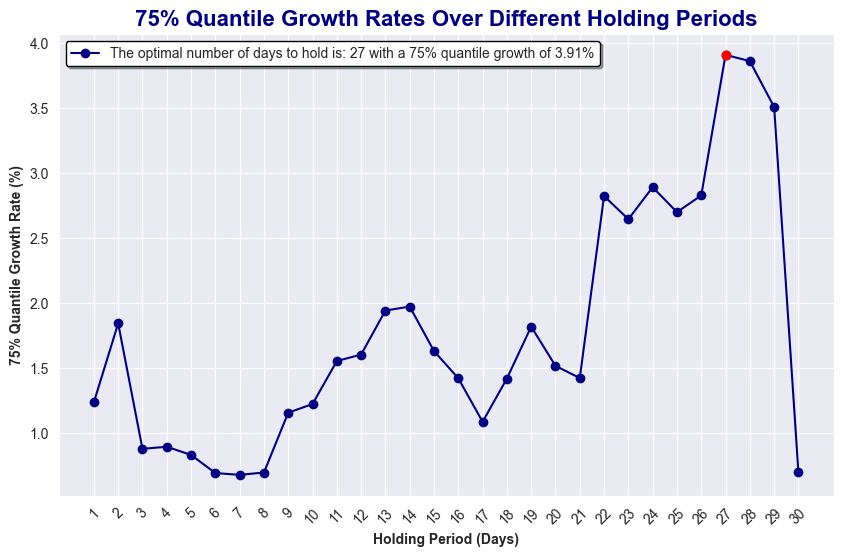

In [83]:
optimal_x = quantiles.idxmax()  # Get the day with the highest 75% quantile
#print(f"The optimal number of days to hold is: {optimal_x} with a 75% quantile growth of {round(quantiles[optimal_x], 2)}%")
text = f"The optimal number of days to hold is: {optimal_x} with a 75% quantile growth of {round(quantiles[optimal_x], 2)}%"
# Example data
days = list(quantiles.keys())
quantile_growth = list(quantiles)

plt.figure(figsize=(10, 6))
plt.plot(days, quantile_growth, marker='o', linestyle='-', color='navy')
# make x=27 red
plt.plot(27, quantiles[27], marker='o', color='red', linestyle='None', label='Optimal Day (27)')
plt.title('75% Quantile Growth Rates Over Different Holding Periods', weight='bold', size=16, color='navy')
plt.xlabel('Holding Period (Days)', weight='bold'),
plt.xticks(days, rotation=45)
plt.ylabel('75% Quantile Growth Rate (%)', weight='bold')
# include text in legend
plt.legend([text], loc='upper left', fontsize=10, facecolor='white', edgecolor='black', shadow=True)
plt.grid(True)
plt.show()

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that quantiles is a Series or convert it if necessary
# Example data
days = list(quantiles.keys())
quantile_growth = list(quantiles.values())

# Convert data to a 2D array with 1 row and n columns (n is number of days)
data = np.array([quantile_growth])

# Create a heatmap
plt.figure(figsize=(14, 3))  # Wide figure to accommodate all days
ax = sns.heatmap(data, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True,
                 xticklabels=days, yticklabels=['Growth Rate'])

# Adding titles and labels
plt.title('75% Quantile Growth Rates Over Different Holding Periods', weight='bold', size=16)
plt.xlabel('Holding Period (Days)', weight='bold')
plt.yticks([])  # Hide y ticks as there's only one row
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Highlight the optimal day
optimal_x = quantiles.idxmax()
optimal_value = round(quantiles[optimal_x], 2)
plt.text(optimal_x - 0.5, 0, f'{optimal_value}%', ha='center', va='center', color='red', weight='bold')

plt.show()


TypeError: 'numpy.ndarray' object is not callable

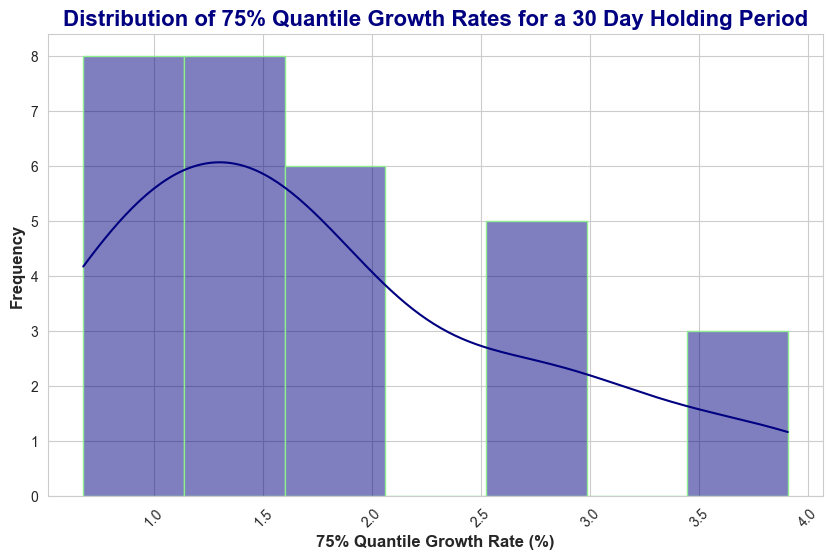

In [49]:
# histplot for 75% quantile growth rates
plt.figure(figsize=(10, 6))
plt.title('Distribution of 75% Quantile Growth Rates for a 30 Day Holding Period', size=16, weight='bold', color='navy')
plt.xlabel('75% Quantile Growth Rate (%)', weight='bold', size=12),
plt.ylabel('Frequency', weight='bold', size=12)
plt.xticks(rotation=45)
sns.histplot(quantiles, kde=True, color='navy', edgecolor='lightgreen', bins=7);

## ***`Question 3: Is Growth Concentrated in the Largest Stocks?`***
---

Get the share of days (percentage as int) when Large Stocks outperform (growth_7d - growth over 7 periods back) the Largest stocks?

Reuse [Code Snippet 5] to obtain OHLCV stats for 33 stocks for 10 full years of data (2014-01-01 to 2023-12-31). You'll need to download slightly more data (7 periods before 2014-01-01 to calculate the growth_7d for the first 6 days correctly):

> US_STOCKS = ['MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO','V', 'JPM']

> EU_STOCKS = ['NVO','MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE','IDEXY','CDI.PA']

> INDIA_STOCKS = ['RELIANCE.NS','TCS.NS','HDB','BHARTIARTL.NS','IBN','SBIN.NS','LICI.NS','INFY','ITC.NS','HINDUNILVR.NS','LT.NS']

> LARGEST_STOCKS = US_STOCKS + EU_STOCKS + INDIA_STOCKS

Now let's add the top 12-22 stocks (as of end-April 2024):

> NEW_US = ['TSLA','WMT','XOM','UNH','MA','PG','JNJ','MRK','HD','COST','ORCL']

> EW_EU = ['PRX.AS','CDI.PA','AIR.PA','SU.PA','ETN','SNY','BUD','DTE.DE','ALV.DE','MDT','AI.PA','EL.PA']

> NEW_INDIA = ['BAJFINANCE.NS','MARUTI.NS','HCLTECH.NS','TATAMOTORS.NS','SUNPHARMA.NS','ONGC.NS','ADANIENT.NS','ADANIENT.NS','NTPC.NS','KOTAKBANK.NS','TITAN.NS']

> LARGE_STOCKS = NEW_EU + NEW_US + NEW_INDIA

You should be able to obtain stats for 33 LARGEST STOCKS and 32 LARGE STOCKS (from the actual stats on Yahoo Finance)

Calculate  growth_7d for every stock and every day. Get the average daily growth_7d for the LARGEST_STOCKS group vs. the LARGE_STOCKS group.

For example, for the first of data you should have:
| Date       | ticker_category | growth_7d |
|------------|-----------------|-----------|
| 2014-01-01 | LARGE           | 1.011684  |
| 2014-01-01 | LARGEST         | 1.011797  |

On that day, the LARGEST group was growing faster than LARGE one (new stocks).

Calculate the number of days when the LARGE GROUP (new smaller stocks) outperforms the LARGEST GROUP, divide it by the total number of trading days (which should be 2595 days), and convert it to a percentage (closest INTEGER value). For example, if you find that 1700 out of 2595 days meet this condition, it means that 1700/2595 = 0.655, or approximately 66% of days, the LARGE stocks were growing faster than the LARGEST ones. This suggests that you should consider extending your dataset with more stocks to seek higher growth.

HINT: you can use `pandas.pivot_table()` to "flatten" the table (LARGE and LARGEST growth_7d as columns)

---

In [ ]:
0.011797	0.009288

- Define stock symbols:

In [2]:
US_STOCKS = ['MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO','V', 'JPM']

EU_STOCKS = ['NVO','MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE','IDEXY','CDI.PA']

INDIA_STOCKS = ['RELIANCE.NS','TCS.NS','HDB','BHARTIARTL.NS','IBN','SBIN.NS','LICI.NS','INFY','ITC.NS','HINDUNILVR.NS','LT.NS']

LARGEST_STOCKS = US_STOCKS + EU_STOCKS + INDIA_STOCKS

# Now let's add the top 12-22 stocks (as of end-April 2024):

NEW_US = ['TSLA','WMT','XOM','UNH','MA','PG','JNJ','MRK','HD','COST','ORCL']

NEW_EU = ['PRX.AS','CDI.PA','AIR.PA','SU.PA','ETN','SNY','BUD','DTE.DE','ALV.DE','MDT','AI.PA','EL.PA']

NEW_INDIA = ['BAJFINANCE.NS','MARUTI.NS','HCLTECH.NS','TATAMOTORS.NS','SUNPHARMA.NS','ONGC.NS','ADANIENT.NS','ADANIENT.NS','NTPC.NS','KOTAKBANK.NS','TITAN.NS']

LARGE_STOCKS = NEW_EU + NEW_US + NEW_INDIA

print(f"Largest stocks n = {len(LARGEST_STOCKS)}")
print(f"Large stocks n = {len(LARGE_STOCKS)}")

Largest stocks n = 33
Large stocks n = 34


- Download data:

In [24]:
#start="2014-12-25"
start = "2014-01-01"
end   = "2023-12-31"

# get correct date for 7 business days before the start date:
start = pd.to_datetime(start)
start = start - pd.tseries.offsets.BDay(8)

end = pd.to_datetime(end)

start

Timestamp('2013-12-20 00:00:00')

In [25]:
def download_stock_data(tickers, start, end):
    data = yf.download(tickers, start=start, end=end)
    return data['Adj Close']

# Download data
largest_data = download_stock_data(LARGEST_STOCKS, start, end)
large_data   = download_stock_data(LARGE_STOCKS, start, end)

[*********************100%%**********************]  33 of 33 completed
[*********************100%%**********************]  33 of 33 completed


In [26]:
print(f"N stocks retrieved: {largest_data.shape[-1]}")
print(f"Shape: {largest_data.shape}")
largest_data.head(3)

N stocks retrieved: 33
Shape: (2602, 33)


Ticker,AAPL,ACN,AMZN,ASML,AVGO,BHARTIARTL.NS,BRK-B,CDI.PA,GOOG,HDB,...,NVO,OR.PA,RELIANCE.NS,RMS.PA,SAP,SBIN.NS,SIE.DE,TCS.NS,TTE,V
Date,,,,,,,,,,,,,,,,,,,,,
2013-12-20,17.168137,67.134422,20.110001,82.374268,39.112080,279.667847,115.599998,106.733627,27.412750,15.999452,...,14.722777,104.883652,382.167084,229.327957,71.147751,159.538498,60.687019,859.650085,32.584385,50.254242
2013-12-23,17.827003,67.967888,20.146000,83.058624,39.422535,279.966400,117.040001,105.659119,27.773397,16.215216,...,14.712964,105.009468,382.636688,228.513123,71.688530,160.198990,61.337166,854.987610,32.852558,50.733578
2013-12-24,17.751329,67.767830,19.959999,83.427818,39.846622,277.748749,117.430000,105.738716,27.692204,16.229282,...,14.722777,104.757858,383.405151,227.064575,71.950493,160.271912,NaN,855.656616,32.951054,50.896454


In [27]:
print(f"N stocks retrieved: {large_data.shape[-1]}")
print(f"Shape: {large_data.shape}")
large_data.head(3)

N stocks retrieved: 33
Shape: (2602, 33)


Ticker,ADANIENT.NS,AI.PA,AIR.PA,ALV.DE,BAJFINANCE.NS,BUD,CDI.PA,COST,DTE.DE,EL.PA,...,PRX.AS,SNY,SU.PA,SUNPHARMA.NS,TATAMOTORS.NS,TITAN.NS,TSLA,UNH,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2013-12-20,36.660690,53.294231,47.956329,75.793877,144.690720,80.732056,106.733627,95.20742,8.557540,63.202209,...,NaN,35.407040,48.443974,539.325867,366.868439,218.310349,9.549333,62.705605,20.790005,63.592613
2013-12-23,38.355984,53.256924,47.964905,76.294052,150.547104,80.958542,105.659119,95.33593,8.595561,63.471630,...,NaN,35.488998,48.428352,536.856812,368.782806,218.740036,9.570000,63.560490,20.908148,63.483059
2013-12-24,37.932163,53.432812,48.170799,NaN,148.277145,81.028831,105.738716,95.33593,NaN,63.269577,...,NaN,35.297764,48.608036,528.518616,365.837646,217.880722,10.094000,63.372402,20.945742,63.940601


- Calculate 7 day growth:

In [28]:
def calculate_growth(data):
    return data / data.shift(7) - 1

growth_largest = calculate_growth(largest_data)
growth_large = calculate_growth(large_data)


In [29]:
print(f"Growth largest shape: {growth_largest.shape}")
print(f"Growth large shape: {growth_large.shape}")

Growth largest shape: (2602, 33)
Growth large shape: (2602, 33)


In [30]:
growth_largest.head(9)

Ticker,AAPL,ACN,AMZN,ASML,AVGO,BHARTIARTL.NS,BRK-B,CDI.PA,GOOG,HDB,...,NVO,OR.PA,RELIANCE.NS,RMS.PA,SAP,SBIN.NS,SIE.DE,TCS.NS,TTE,V
Date,,,,,,,,,,,,,,,,,,,,,
2013-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01,NaN,NaN,NaN,NaN,NaN,0.030040,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.007094,NaN,NaN,0.007909,NaN,0.015444,NaN,NaN
2014-01-02,-0.029749,-0.005151,-0.012285,0.001301,0.011334,0.001371,0.00393,0.022222,-0.001776,-0.022852,...,0.020622,0.003195,-0.023710,0.037242,0.000825,-0.009014,-0.000707,0.027477,0.000666,0.013668


In [31]:
growth_large.head(9)

Ticker,ADANIENT.NS,AI.PA,AIR.PA,ALV.DE,BAJFINANCE.NS,BUD,CDI.PA,COST,DTE.DE,EL.PA,...,PRX.AS,SNY,SU.PA,SUNPHARMA.NS,TATAMOTORS.NS,TITAN.NS,TSLA,UNH,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2013-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01,0.035646,NaN,NaN,NaN,0.050544,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.011315,0.003345,0.009403,NaN,NaN,NaN,NaN
2014-01-02,-0.059484,0.010308,0.011447,-0.01157,0.008970,-0.001061,0.022222,-0.007414,-0.024528,0.012469,...,NaN,-0.004042,0.004355,-0.004165,-0.008785,-0.012003,0.045629,0.002959,0.013356,0.012588


- Analysis of Outperformance:

In [42]:
# Calculate daily averages for each group
daily_avg_growth_largest = growth_largest.mean(axis=1)
daily_avg_growth_large   = growth_large.mean(axis=1)

# concat both to see if we get same result as the hint in the task description:
growth_df = pd.concat([daily_avg_growth_largest, daily_avg_growth_large], axis=1)
growth_df.columns = ['Largest', 'Large']

# Compare daily growths
outperform = daily_avg_growth_large > daily_avg_growth_largest
percentage_outperform = outperform.mean() * 100

print(f"Percentage of days when LARGE stocks outperform LARGEST stocks: {int(percentage_outperform)}%")

Percentage of days when LARGE stocks outperform LARGEST stocks: 46%


In [43]:
# check for same result as in task description:
growth_df.head(9)

,Largest,Large
Date,,
2013-12-20,NaN,NaN
2013-12-23,NaN,NaN
2013-12-24,NaN,NaN
2013-12-26,NaN,NaN
2013-12-27,NaN,NaN
2013-12-30,NaN,NaN
2013-12-31,NaN,NaN
2014-01-01,0.011797,0.009288
2014-01-02,-0.001811,-0.000651


In [9]:
daily_avg_growth_largest

Date
2013-12-26         NaN
2013-12-27         NaN
2013-12-30         NaN
2013-12-31         NaN
2014-01-01         NaN
                ...   
2023-12-22    0.013788
2023-12-26    0.014900
2023-12-27    0.013800
2023-12-28    0.009875
2023-12-29    0.004045
Length: 2599, dtype: float64

In [10]:
print(f"Shape: {outperform.shape}")
outperform.value_counts()

Shape: (2599,)


False    1391
True     1208
Name: count, dtype: int64

- Visualization and further analysis:

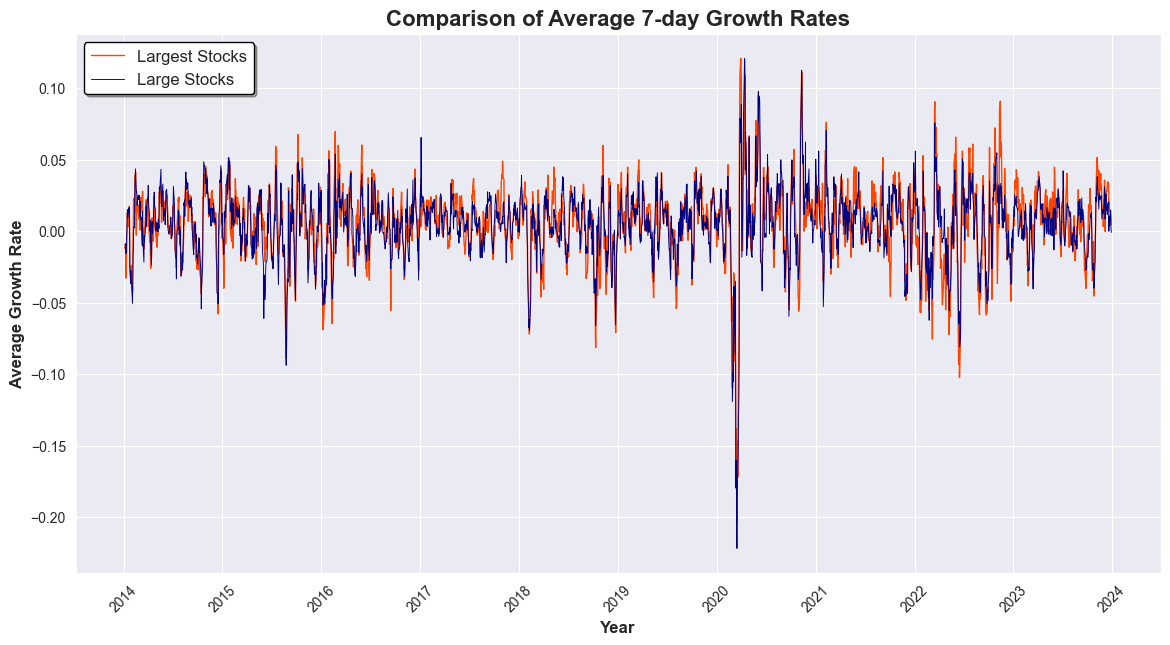

In [11]:
sns.set_style('darkgrid')
plt.figure(figsize=(14, 7))
plt.plot(daily_avg_growth_largest, label='Largest Stocks', color='orangered', linewidth=0.99)
plt.plot(daily_avg_growth_large, label='Large Stocks', color='navy', linewidth=0.66)
plt.title('Comparison of Average 7-day Growth Rates', weight='bold', size=16)
plt.xlabel('Year', weight='bold', size=12)
plt.xticks(rotation=45)
plt.ylabel('Average Growth Rate', weight='bold', size=12)
plt.legend(facecolor='white', fontsize=12, shadow=True, edgecolor='black', fancybox=True, loc='upper left')
plt.show()

## ***`Question 4: Trying Another Technical Indicators strategy`***
---

What's the total gross profit (in THOUSANDS of $) you'll get from trading on CCI (no fees assumption)?

First, run the entire Colab to obtain the full DataFrame of data (after [Code Snippet 9]), and truncate it to the last full 10 years of data (2014-01-01 to 2023-12-31). If you encounter any difficulties running the Colab - you can download it using this link: https://drive.google.com/file/d/1m3Qisfs2XfWk6Sw_Uk5kHLWqwQ0q8SKb/view?usp=sharing.

Let's assume you've learned about the awesome CCI indicator (Commodity Channel Index https://www.investopedia.com/terms/c/commoditychannelindex.asp), and decided to use only it for your operations.

You defined the "defensive" value of a high threshould of 200, and you trade only on Fridays (Date.dt.dayofweek()==4).

That is, every time you see that CCI is >200 for any stock (out of those 33), you'll invest $1000 (each record when CCI>200) at Adj.Close price and hold it for 1 week (5 trading days) in order to sell at the Adj. Close price.

What's the expected gross profit (no fees) that you get in THOUSANDS $ (closest integer value) over many operations in 10 years? One operation calculations: if you invested $1000 and received $1010 in 5 days - you add $10 to gross profit, if you received $980 - add -$20 to gross profit. You need to sum these results over all trades (460 times in 10 years).

Additional:

- Add an approximate fees calculation over the 460 trades from this calculator https://www.degiro.ie/fees/calculator (Product:"Shares, USA and Canada;" Amount per transaction: "1000 EUR"; Transactions per year: "460")
- are you still profitable on those trades?


## ***`[EXPLORATORY] Question 5: Finding Your Strategy for IPOs`***
---

You've seen in the first questions that the median and average investments are negative in IPOs, and you can't blindly invest in all deals.

How would you correct/refine the approach? Briefly describe the steps and the data you'll try to get (it should be generally feasible to do it from public sources - no access to internal data of companies)?

E.g. (some ideas) Do you want to focus on the specific vertical? Do you want to build a smart comparison vs. existing stocks on the market? Or you just will want to get some features (which features?) like total number of people in a company to find a segment of "successful" IPOs?

### *`Answer`*

Investment Strategy for AI-Oriented IPOs

#### 1. Vertical Specialization
Focusing on a specific AI vertical can sharpen investment decisions by deepening sector-specific knowledge:

- Healthcare AI: Target companies innovating in diagnostics and patient management.
- Finance AI: Focus on firms revolutionizing trading and fraud detection.
- Autonomous Technologies: Consider businesses advancing in self-driving and robotics.

#### 2. Market Comparison
Evaluate AI IPO candidates against existing market players:

- Financial Comparison: Assess revenue growth, profitability, and cash flow.
- Market Positioning: Review innovation levels, market share, and technological superiority.
- Customer and Strategy Analysis: Analyze customer base diversity and business scalability.

#### 3. Key AI-Specific Indicators
Consider unique metrics that shed light on AI companies’ potential:

- R&D Investment: Indicates future growth potential though may impact short-term profits.
- Patent Portfolio: Reflects innovative capability and technological edge.
- Talent and Partnerships: The expertise of the team and collaborations that could boost R&D efforts.

#### 4. AI-Specific Data Usage
Utilize datasets that offer insights specific to AI enterprises:

- Research Impact: Evaluate the influence of technical publications and team's academic contributions.
- Open-source Engagement: Check the company’s involvement in the AI community through open-source projects.
- Regulatory Standing: Especially critical for companies in regulated sectors like healthcare.

#### 5. Data-Driven Investment
Employ advanced analytics to predict IPO success and enhance decision-making:

- Predictive Modeling: Use historical IPO performance data to forecast outcomes.
- Sentiment Analysis: Analyze market sentiment from news, reports, and social media to gauge public and investor perceptions.

#### 6. Continuous Performance Monitoring
Post-investment, it's essential to track the company’s adherence to its IPO promises:

- Earnings Tracking: Monitor if the company meets its quarterly and annual projections.
- Ongoing Innovation: Ensure the company continues to lead or catch up with technological advancements.
- Market Adaptability: Observe how the company responds to market and technological changes.
#
Conclusion:
#
Investing in AI-oriented IPOs requires a multifaceted approach. By integrating detailed sector analysis, financial comparisons, and AI-specific data insights, investors can more effectively gauge which IPOs have the potential for success, thereby optimizing their investment strategies in this high-growth area.

In [ ]:

When investing in AI-oriented IPOs, it's crucial to adopt a strategic approach given the typical volatility and risk associated with such investments. Specializing in a specific AI vertical, such as healthcare or autonomous technologies, allows for focused analysis and deeper understanding. Comparing potential IPOs against established market players on financial health, innovation, and market positioning can provide essential insights. Utilizing key AI-specific indicators such as R&D spending and patent portfolios, along with AI-specific datasets, can further refine investment choices. Implementing data-driven investment strategies through predictive analytics and sentiment analysis helps in anticipating IPO success. Continuous post-IPO performance tracking ensures that investments continue to meet their strategic goals, adapting as necessary to evolving market conditions. This multifaceted approach maximizes the potential for successful investments in the dynamic AI sector.